In [ ]:
#pip install sktime

In [37]:
#pip install tslearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tslearn-0.6.3-py3-none-any.whl.metadata (14 kB)
Using cached tslearn-0.6.3-py3-none-any.whl (374 kB)
DEPRECATION: markdown 3.3.5 has a non-standard dependency specifier importlib-metadata>='4.4'; python_version < "3.10". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of markdown or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sktime.transformations.panel.rocket import Rocket
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneGroupOut
import time

import pandas as pd
import numpy as np

In [3]:
import sktime
print(sktime.__version__)

0.16.1


In [4]:
data_dir = "/home/sagemaker-user/MoCapRunFatigue/data/"

# First lets make sure we can replicate the results github repo referenced in the paper

In [5]:
#read in the data
filename = "Accel_mag_all.csv"
data = pd.read_csv(f"{data_dir}{filename}", header = None)

In [6]:
#split the data into X,y and an id variable

X = data.iloc[:,2:].values

y =  data[1].values

participant_no =  data[0].values

In [7]:
#initiate the leave one subject out split

logo = LeaveOneGroupOut()

logo.get_n_splits(X, y, participant_no)

19

In [8]:
#define the pipeline to perform Rocket fature mapping/extraction, scaler and ridge classification

rocket_pipeline_ridge = make_pipeline(
    Rocket(random_state=0), 
    StandardScaler(), 
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)

#### Here we define and run the global model, 1 model to be used on all runners
we will make a few changes.. 

1. we need to convert the X variable from a 2d to 3d array. Im not sure how the paper go away without doing this perhaps an older version of a function allowed this.
2. We will calculate how long this process takes to run.

In [9]:
#convert X from a 2d array to a 3d array
X_3D = X.reshape(X.shape[0], 1, X.shape[1])

In [10]:
Rocket_score_glob = []

start_time = time.time() #initializing the start time

for i, (train_index, test_index) in enumerate(logo.split(X_3D, y, participant_no)):
    rocket_pipeline_ridge.fit(X_3D[train_index], y[train_index])

    Rocket_score = rocket_pipeline_ridge.score(X_3D[test_index],y[test_index])
    Rocket_score_glob = np.append(Rocket_score_glob, Rocket_score)
    
end_time = time.time() #recording the end time
    
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code took {elapsed_time} seconds to run.") 



The code took 2776.404061317444 seconds to run.


#### We can see that the above code took ~2750 seconds or about 45 minutes, later on we will try to make this faster

In [11]:
print("Global Model Results")
print(f"mean accuracy: {np.mean(Rocket_score_glob)}")
print(f"standard deviation: {np.std(Rocket_score_glob)}")
print(f"minimum accuracy: {np.min(Rocket_score_glob)}")
print(f"maximum accuracy: {np.max(Rocket_score_glob)}")

Global Model Results
mean accuracy: 0.5919805636306338
standard deviation: 0.10360659996594646
minimum accuracy: 0.4709480122324159
maximum accuracy: 0.8283582089552238


### We have successfully gotten an identical match for the global model, now lets do the same for the individual model

Like the global model I will make a few changes...
1. Again using the 3D version of X.
2. Also calculating how long this process takes to run.

In [12]:
Rocket_score_pers = []

start_time = time.time() #initializing the start time

for i, (train_index, test_index) in enumerate(logo.split(X_3D, y, participant_no)):
    
    #print(f"Participant: {participant_no[test_index][0]}")
    label = y[test_index]
    X_S = X_3D[test_index]
    
    # Identify the indices for each class
    class_0_indices = np.where(label == 'NF')[0]
    class_1_indices = np.where(label == 'F')[0]
    
    # Split each class into train and test using indexing
    class_0_split_index = int(0.66 * len(class_0_indices))
    class_1_split_index = int(0.66 * len(class_1_indices))

    X_train = np.concatenate((X_S[class_0_indices[:class_0_split_index]], X_S[class_1_indices[:class_1_split_index]]), axis=0)
    y_train = np.concatenate((label[class_0_indices[:class_0_split_index]], label[class_1_indices[:class_1_split_index]]), axis=0)
    
    X_test = np.concatenate((X_S[class_0_indices[class_0_split_index:]],X_S[class_1_indices[class_1_split_index:]]), axis=0)
    y_test = np.concatenate((label[class_0_indices[class_0_split_index:]], label[class_1_indices[class_1_split_index:]]), axis=0)
    
    rocket_pipeline_ridge.fit(X_train, y_train)

    Rocket_score_pers = np.append(Rocket_score_pers, rocket_pipeline_ridge.score(X_test,y_test))
    
end_time = time.time() #recording the end time
    
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code took {elapsed_time} seconds to run.")

The code took 138.11293983459473 seconds to run.


#### We see that this code took ~ 2 minutes to run, we will see if we can speed this up later

In [13]:
#now lets print the results

print("Personalised Model Results")
print(f"mean accuracy: {np.mean(Rocket_score_pers)}")
print(f"standard deviation: {np.std(Rocket_score_pers)}")
print(f"minimum accuracy: {np.min(Rocket_score_pers)}")
print(f"maximum accuracy: {np.max(Rocket_score_pers)}")

Personalised Model Results
mean accuracy: 0.9517626092184379
standard deviation: 0.07750979452994386
minimum accuracy: 0.7037037037037037
maximum accuracy: 1.0


#### We can see that we got the exact same results!

## Now that we have succesfully replicated the results lets, see if we can optimize the code and make it run faster
1. Let try using the joblib package and the parallel function to do so, and try to beat the 45 minute mark!

In [15]:
from joblib import Parallel, delayed
import os

In [16]:
# Create a pipeline with the Rocket transformer and a Ridge classifier
Rocket_score_glob = []
scores = []

start_time = time.time() #initializing the start time

# Define a function to train and evaluate the model
def train_and_evaluate(train_index, test_index):
    rocket_pipeline_ridge.fit(X_3D[train_index], y[train_index])
    score = rocket_pipeline_ridge.score(X_3D[test_index], y[test_index])
    return score, participant_no[test_index][0]

# Perform cross-validation with multiprocessing
Rocket_score_glob = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(train_index, test_index) for train_index, test_index in logo.split(X_3D, y, participant_no))

end_time = time.time() #recording the end time
    
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code took {elapsed_time} seconds to run.")


The code took 204.4248447418213 seconds to run.


Wow this was way faster all the way down to ~2.5 minutes, that's 18x faster and will make generation future iterations and improvements much faster

We need to make sure that the results are the same, because sometimes parallel processing can cause issues.

In [17]:
Rocket_score_glob.sort(key=lambda x: x[1])  # Sort by group identifier
global_scores = [score for score, group in Rocket_score_glob] 

In [18]:
print("Global Model Results with Parallel Processing")
print(f"mean accuracy: {np.mean(global_scores)}")
print(f"standard deviation: {np.std(global_scores)}")
print(f"minimum accuracy: {np.min(global_scores)}")
print(f"maximum accuracy: {np.max(global_scores)}")

Global Model Results with Parallel Processing
mean accuracy: 0.5919805636306338
standard deviation: 0.10360659996594646
minimum accuracy: 0.4709480122324159
maximum accuracy: 0.8283582089552238


##### Great the results match!

Now lets do the same for the individual models. I do not expect quite the same level of improvement but still some. 

In [19]:
# Define your function here
start_time = time.time() #initializing the start time

def process_split(i, train_index, test_index):
    label = y[test_index]
    X_S = X_3D[test_index]
    
    # Identify the indices for each class
    class_0_indices = np.where(label == 'NF')[0]
    class_1_indices = np.where(label == 'F')[0]
    
    # Split each class into train and test using indexing
    class_0_split_index = int(0.66 * len(class_0_indices))
    class_1_split_index = int(0.66 * len(class_1_indices))

    X_train = np.concatenate((X_S[class_0_indices[:class_0_split_index]], X_S[class_1_indices[:class_1_split_index]]), axis=0)
    y_train = np.concatenate((label[class_0_indices[:class_0_split_index]], label[class_1_indices[:class_1_split_index]]), axis=0)
    
    X_test = np.concatenate((X_S[class_0_indices[class_0_split_index:]],X_S[class_1_indices[class_1_split_index:]]), axis=0)
    y_test = np.concatenate((label[class_0_indices[class_0_split_index:]], label[class_1_indices[class_1_split_index:]]), axis=0)
    
    rocket_pipeline_ridge.fit(X_train, y_train)

    return rocket_pipeline_ridge.score(X_test,y_test)

# Create an iterable for your function's inputs
inputs = list(enumerate(logo.split(X_3D, y, participant_no)))

# Use Parallel and delayed to run your function in parallel
Rocket_score_pers = Parallel(n_jobs=-1)(delayed(process_split)(i, train_index, test_index) for i, (train_index, test_index) in inputs)

end_time = time.time() #recording the end time
    
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code took {elapsed_time} seconds to run.")

The code took 12.075503826141357 seconds to run.


Great this code ran in only 14 seconds a ~6x improvement from the non parallel way! now lets check to make sure the results match!

In [20]:
print("Personalised Model Results")
print(f"mean accuracy: {np.mean(Rocket_score_pers)}")
print(f"standard deviation: {np.std(Rocket_score_pers)}")
print(f"minimum accuracy: {np.min(Rocket_score_pers)}")
print(f"maximum accuracy: {np.max(Rocket_score_pers)}")

Personalised Model Results
mean accuracy: 0.9517626092184379
standard deviation: 0.07750979452994386
minimum accuracy: 0.7037037037037037
maximum accuracy: 1.0


Great the results match!

#### Now that we have the code setup and optimized for speed lets begin trying to improve the accuracy.
We will try the following approaches...
1. Changing the train/test split value
2. Changing the way the train/test split is performed
3. Changing the list of features
4. Rolling Barycenter Smoothing of Inputs

Due to the higher performance of the individual models over the global model we will focus our efforts on the individual models.

#### 1. Change the train/test split value

Typical train test splits in machine learning range from 60/40 to 80/20. A general rule of thumb is that with very large data sets you can use a split closer to 60/40 but as the data set gets smalled in size one should move toward the 80/20 split. The reason being is that most models need a minimum number of training examples, although this does mean less test examples, but its a sacrifice that comes with smaller data sets. We will try this with 0.6, 0.7 and 0.8 to see which split performs best. Expecting 0.7 to yield the best results. 

In [21]:
#lets start by making the train/test split value a variable that can easily be changed
split_ratios = [0.6, 0.65, 0.7, 0.75, 0.8]

In [22]:

# Define your function here


def process_split(i, train_index, test_index, split_ratio):
    label = y[test_index]
    X_S = X_3D[test_index]
    
    # Identify the indices for each class
    class_0_indices = np.where(label == 'NF')[0]
    class_1_indices = np.where(label == 'F')[0]
    
    # Split each class into train and test using indexing
    class_0_split_index = int(split_ratio * len(class_0_indices))
    class_1_split_index = int(split_ratio * len(class_1_indices))

    X_train = np.concatenate((X_S[class_0_indices[:class_0_split_index]], X_S[class_1_indices[:class_1_split_index]]), axis=0)
    y_train = np.concatenate((label[class_0_indices[:class_0_split_index]], label[class_1_indices[:class_1_split_index]]), axis=0)
    
    X_test = np.concatenate((X_S[class_0_indices[class_0_split_index:]],X_S[class_1_indices[class_1_split_index:]]), axis=0)
    y_test = np.concatenate((label[class_0_indices[class_0_split_index:]], label[class_1_indices[class_1_split_index:]]), axis=0)
    
    rocket_pipeline_ridge.fit(X_train, y_train)

    return rocket_pipeline_ridge.score(X_test,y_test)

# Create an iterable for your function's inputs
inputs = list(enumerate(logo.split(X_3D, y, participant_no)))


# Use Parallel and delayed to run your function in parallel for each split ratio
for split_ratio in split_ratios:
    start_time = time.time() #initializing the start time
    Rocket_score_pers = Parallel(n_jobs=-1)(delayed(process_split)(i, train_index, test_index, split_ratio) for i, (train_index, test_index) in inputs)

    print(f"Personalised Model Results for {split_ratio}")
    print(f"mean accuracy: {np.mean(Rocket_score_pers)}")
    print(f"standard deviation: {np.std(Rocket_score_pers)}")
    print(f"minimum accuracy: {np.min(Rocket_score_pers)}")
    print(f"maximum accuracy: {np.max(Rocket_score_pers)}")

    end_time = time.time() #recording the end time
    
    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Print the elapsed time
    print(f"The code took {elapsed_time} seconds to run for {split_ratio}")
    print('--------------------------------')

Personalised Model Results for 0.6
mean accuracy: 0.9487207704285742
standard deviation: 0.08552510129028004
minimum accuracy: 0.6984126984126984
maximum accuracy: 1.0
The code took 13.563263177871704 seconds to run for 0.6
--------------------------------
Personalised Model Results for 0.65
mean accuracy: 0.9505930091805951
standard deviation: 0.08175057049965348
minimum accuracy: 0.7090909090909091
maximum accuracy: 1.0
The code took 13.330380201339722 seconds to run for 0.65
--------------------------------
Personalised Model Results for 0.7
mean accuracy: 0.9575451151576745
standard deviation: 0.06554067039138353
minimum accuracy: 0.775
maximum accuracy: 1.0
The code took 13.337809562683105 seconds to run for 0.7
--------------------------------
Personalised Model Results for 0.75
mean accuracy: 0.9655851315595222
standard deviation: 0.044153310653484754
minimum accuracy: 0.8484848484848485
maximum accuracy: 1.0
The code took 13.429238080978394 seconds to run for 0.75
-------------

Great so we see that the model's classification accuracy is highest with the 75/25 split. Lets use this moving forward! However, because we have reduce the size of our test set the chances our model is overfitting are now higher. To gaurd against this we will perform cross validation (CV) as described below. 

#### 2. Improve the train test split approach
Currently the train test split approach is quite simple and takes the first 75% of data points as the train and the remaining 25% as test, making sure to include equal representation of the fatigued and non fatigued state in each. The fear is that this approach may produce overly optimistic test results.

A common technique in train/test split technique in machine learning is Cross Validation (CV) which involves creating a few different train and test splits (folds). The goal of CV is to build a more robust model that is less likely to overfit and more likely to give a more realistic look into how the model will perform in the real world. 

However, traditional CV does not work for time series because the data is sequential and the order must be retained. We will try a CV techique specifically designed for time series called "Rolling Block" or "Walk Forward Validation". This technique splits the data into n blocks and then splits those blocks into train and test sets. We will go one step further to ensure that there is no data leakage between blocks or between the train and test sets within a block by introducing a gap of size z between blocks and between the train and test sets. Please see below visual for how this works. 

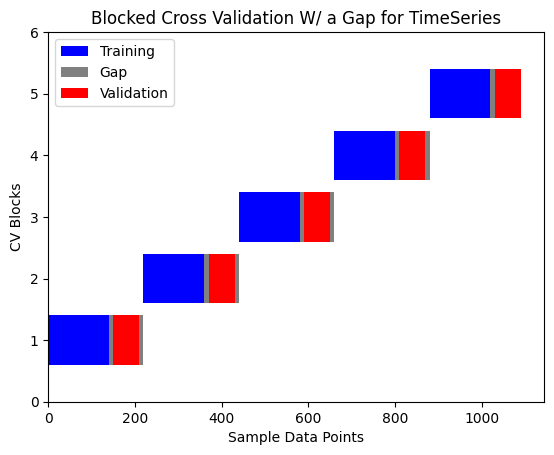

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define the total number of data points
total_points = 1000

# Define the size of the training set, validation set, and the gap
train_size = 140
val_size = 60
gap_size = 10

# Define the number of blocks
num_blocks = 5

# Define the gap between blocks
block_gap = 10

# Create a loop to iterate over the blocks
start_point = 0

for block in range(num_blocks):

    # Define the training set, validation set, and the gaps
    train_range = range(start_point, start_point + train_size)
    gap_range = range(start_point + train_size, start_point + train_size + gap_size)
    val_range = range(start_point + train_size + gap_size, start_point + train_size + gap_size + val_size)

    # Plot the training set, validation set, and the gaps
    plt.barh(block + 1, train_size, left=start_point, color='blue', label='Training' if block == 0 else "_nolegend_")
    plt.barh(block + 1, gap_size, left=start_point + train_size, color='grey', label='Gap' if block == 0 else "_nolegend_")
    plt.barh(block + 1, val_size, left=start_point + train_size + gap_size, color='red', label='Validation' if block == 0 else "_nolegend_")

    # Add a gap after each block except the last one
    if block < num_blocks - 1:
        gap_after_block_range = range(start_point + train_size + gap_size + val_size, start_point + train_size + gap_size + val_size + block_gap)
        plt.barh(block + 1, block_gap, left=gap_after_block_range[0], color='grey', label="_nolegend_")
        start_point = gap_after_block_range[-1] + 1

# Add a legend
plt.legend()

# Add x and y axis labels
plt.xlabel('Sample Data Points')
plt.ylabel('CV Blocks')
plt.title('Blocked Cross Validation W/ a Gap for TimeSeries')
# Display the plot
plt.ylim(0, num_blocks + 1)
plt.show()

Great so now that we now what this blocking cross validation technique looks like visually lets implement it below! We will try with the same 5 splits to see which performs the best. As can be seen in the above visual each train/test set is now smaller and there is reason to believe that the 75/25 split will not leave too few samples in the test set and the 60/40, 65/35 or 70/30 splits may perform better. 

In [24]:

n_blocks = 5
gap = 0

def train_and_evaluate(i, X_S_F, X_S_NF, label_F, label_NF, block_size_F, block_size_NF, split_ratios,model):
    # Adjust the start and end indices taking the gap into account
    start_index_F = i * (block_size_F + gap)
    start_index_NF = i * (block_size_NF + gap)
    end_index_F = min((i + 1) * (block_size_F + gap), len(X_S_F))
    end_index_NF = min((i + 1) * (block_size_NF + gap), len(X_S_NF))

    # Calculate the train/test split indices
    split_index_F = start_index_F + int(block_size_F * split_ratio)
    split_index_NF = start_index_NF + int(block_size_NF * split_ratio)

    # Create a gap between the training and validation sets
    X_train_F = X_S_F[start_index_F:split_index_F]
    X_test_F = X_S_F[split_index_F + gap:end_index_F]
    y_train_F = label_F[start_index_F:split_index_F]
    y_test_F = label_F[split_index_F + gap:end_index_F]

    X_train_NF = X_S_NF[start_index_NF:split_index_NF]
    X_test_NF = X_S_NF[split_index_NF + gap:end_index_NF]
    y_train_NF = label_NF[start_index_NF:split_index_NF]
    y_test_NF = label_NF[split_index_NF + gap:end_index_NF]

    # Combine 'F' and 'NF' training and testing data
    X_train = np.concatenate((X_train_F, X_train_NF), axis=0)
    X_test = np.concatenate((X_test_F, X_test_NF), axis=0)
    y_train = np.concatenate((y_train_F, y_train_NF), axis=0)
    y_test = np.concatenate((y_test_F, y_test_NF), axis=0)
    
    if model=='ridge':
        # Train and evaluate your model here...
        rocket_pipeline_ridge.fit(X_train, y_train)
        personal_score = rocket_pipeline_ridge.score(X_test, y_test)
    if model == 'catboost':
        rocket_pipeline_catboost.fit(X_train, y_train)
        personal_score = rocket_pipeline_catboost.score(X_test, y_test)
    if model=='lstm':
        # Define LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

        # Fit model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Evaluate model
        _, personal_score = model.evaluate(X_test, y_test, verbose=0)
    return personal_score

def run_model_and_splits(X_3D,y,participant_no,logo,n_blocks,gap,model):
    for train_index, test_index in logo.split(X_3D, y, participant_no):
        X_S = X_3D[test_index]
        label = y[test_index]

        # Separate the 'F' and 'NF' samples
        F_indices = np.where(label == 'F')[0]
        NF_indices = np.where(label == 'NF')[0]
        X_S_F = X_S[F_indices]
        X_S_NF = X_S[NF_indices]
        label_F = label[F_indices]
        label_NF = label[NF_indices]

        # Calculate the block sizes taking the gap into account
        block_size_F = (len(X_S_F) - (n_blocks * gap)) // n_blocks
        block_size_NF = (len(X_S_NF) - (n_blocks * gap)) // n_blocks

        # Check if there are enough samples
        if block_size_F <= 0 or block_size_NF <= 0:
            print(f"Skipping runner {participant_no[test_index][0]} due to insufficient samples")
            continue

        # Use joblib to parallelize the inner loop
        personal_scores = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(i, X_S_F, X_S_NF, label_F, label_NF, block_size_F, block_size_NF, split_ratio,model) for i in range(n_blocks))

        # Calculate the mean score for the current runner and add it to the list along with the runner id
        Rocket_score_pers.append((np.mean(personal_scores), participant_no[test_index][0]))

    end_time = time.time()

    print(f'The code took {end_time - start_time} seconds to run for train size {split_ratio}.')

    personal_scores_final = [score for score, _ in Rocket_score_pers]
    return(personal_scores_final)



In [25]:
for split_ratio in split_ratios:
    Rocket_score_pers = []
    start_time = time.time()
    
    personal_scores_final = run_model_and_splits(X_3D,y,participant_no,logo,n_blocks,gap,'ridge')

    print(f"Personalised Model Results for split: {split_ratio}")
    print(f"mean accuracy: {np.mean(personal_scores_final)}")
    print(f"standard deviation: {np.std(personal_scores_final)}")
    print(f"minimum accuracy: {np.min(personal_scores_final)}")
    print(f"maximum accuracy: {np.max(personal_scores_final)}")
    print('-----------------------------')

The code took 35.19989228248596 seconds to run for train size 0.6.
Personalised Model Results for split: 0.6
mean accuracy: 0.9607904756003401
standard deviation: 0.060236734927838965
minimum accuracy: 0.7333333333333333
maximum accuracy: 1.0
-----------------------------
The code took 35.14013648033142 seconds to run for train size 0.65.
Personalised Model Results for split: 0.65
mean accuracy: 0.9596857072510867
standard deviation: 0.07156899501577584
minimum accuracy: 0.6736842105263158
maximum accuracy: 1.0
-----------------------------
The code took 35.06776213645935 seconds to run for train size 0.7.
Personalised Model Results for split: 0.7
mean accuracy: 0.9635377320310831
standard deviation: 0.06705303009741463
minimum accuracy: 0.6941176470588235
maximum accuracy: 1.0
-----------------------------
The code took 35.202035427093506 seconds to run for train size 0.75.
Personalised Model Results for split: 0.75
mean accuracy: 0.9595424425121346
standard deviation: 0.0749168431451

here we see that the 60/40 split yields the best results. I believe that this yields more realistic and slightly better results than the original paper given the same feature set. For example, the results between the splits when applying blocking seem to be more consistent from one split to the next. This is a great sign that we are not overfitting.

However I'd like to point out that the 60/40 spit may not be the ideal split after adding additional variables or using the smoothing techniques mentioned above so we will continue to test for the best splits along the way. 

### 3. Changing the list of features.
Current we are just using the magnitude of acceleration. Lets try two other feature sets.
1. Magnitude of acceleration and the gyroscope data in the y direction. There is reason to believe that gyroscope in the y direction could provide valuable information because as runners fatigue their upper body often times twist more around the veritical axis because they no longer have energy to keep it still. 

In [27]:
df_y_gyro = pd.read_csv(f"{data_dir}Gyro_Y_all.csv", header=None) #read in the gyro_y data
data_points = len(df_y_gyro)
df_y_gyro.iloc[:, 2:] = df_y_gyro.iloc[:, 2:].abs()
df_y_gyro['data_type'] = 'mag_gyro_y'
data['data_type'] = 'mag_accel'
mag_accel_and_mag_y_gyro = pd.concat([df_y_gyro, data], axis=0).reset_index(drop=True)
mag_accel_and_mag_y_gyro = mag_accel_and_mag_y_gyro.rename(columns={0: 'runner_id', 1: 'fatigued'})
mag_accel_and_mag_y_gyro

runner_id fatigued       2       3      4      5      6      7      8  \
0              4        F   26.90   41.60  27.50  17.20  17.00   7.94  16.70   
1              4        F   87.30   76.80  72.30  69.60  66.00  64.00  63.60   
2              4        F   87.10   70.80  61.60  57.70  55.60  54.30  52.00   
3              4        F  104.00  101.00  81.40  72.50  69.30  63.10  58.40   
4              4        F   58.20   53.60  66.80  76.10  79.10  82.50  85.90   
...          ...      ...     ...     ...    ...    ...    ...    ...    ...   
12007         23       NF    7.50    7.74   7.42   7.18   6.75   6.12   5.59   
12008         23       NF    4.28    4.57   4.24   4.14   3.65   3.10   1.79   
12009         23       NF    1.15    1.57   4.37   5.32   7.89   8.31  14.40   
12010         23       NF    1.84    1.11   2.99   1.36   2.83   2.96   3.69   
12011         23       NF   15.30   15.90  15.10  15.30  15.50  14.80  14.40   

           9  ...     173     174     175     176     177     178     179  \
0      38.10  ...  119.00  120.00  114.00   95.30   85.60   99.60  114.00   
1      61.20  ...  189.00  154.00  140.00  150.00  162.00  158.00  141.00   
2      44.90  ...  132.00  158.00  174.00  165.00  149.00  140.00  135.00   
3      56.00  ...   62.70   72.80   64.20   47.40   48.90   52.70   40.40   
4      84.90  ...  162.00  183.00  199.00  191.00  176.00  174.00  172.00   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
12007   5.21  ...    7.32    6.99    6.13    5.78    5.40    5.47    5.24   
12008   1.91  ...    5.35    4.95    4.91    4.61    4.45    3.80    3.46   
12009  19.30  ...    7.44    7.04    6.95    6.69    6.68    6.62    6.13   
12010   5.78  ...   19.00   18.40   19.60   18.40   17.80   17.80   15.40   
12011  14.50  ...   13.30   13.30   13.10   12.40   12.10   12.00   10.90   

          180     181   data_type  
0       89.90   28.50  mag_gyro_y  
1      121.00  103.00  mag_gyro_y  
2      124.00  107.00  mag_gyro_y  
3       40.40   73.50  mag_gyro_y  
4      144.00   95.00  mag_gyro_y  
...       ...     ...         ...  
12007    5.15    4.77   mag_accel  
12008    2.91    2.52   mag_accel  
12009    5.82    5.42   mag_accel  
12010   17.40   13.40   mag_accel  
12011   10.30   12.40   mag_accel  

[12012 rows x 183 columns]

In [28]:
def create_non_smoothed_multi_feature_X_y(df):
    data_types = df['data_type'].unique().tolist() #finds the unique number of features
    X = df.iloc[:, ~df.columns.isin(['runner_id', 'fatigued', 'data_type'])].values
    number_of_features = len(data_types)
    # Calculate the size of the first dimension
    first_dim_size = X.shape[0] // number_of_features

    # Split the array into a list of arrays, each representing a feature
    feature_arrays = np.split(X, number_of_features)

    # Reshape each feature array and stack them along a new axis
    X_3D = np.stack([feature_array.reshape(-1, 180) for feature_array in feature_arrays], axis=1)


    y =  df['fatigued'].values[:data_points]

    participant_no =  df['runner_id'].values[:data_points]
    return(X_3D,y,participant_no)

In [29]:
X_3D,y,participant_no=create_non_smoothed_multi_feature_X_y(mag_accel_and_mag_y_gyro)
for split_ratio in split_ratios:
    Rocket_score_pers = []
    start_time = time.time()
    
    personal_scores_final = run_model_and_splits(X_3D,y,participant_no,logo,n_blocks,gap,'ridge')

    print(f"Personalised Model Results for split: {split_ratio}")
    print(f"mean accuracy: {np.mean(personal_scores_final)}")
    print(f"standard deviation: {np.std(personal_scores_final)}")
    print(f"minimum accuracy: {np.min(personal_scores_final)}")
    print(f"maximum accuracy: {np.max(personal_scores_final)}")
    print('-----------------------------')

The code took 64.5587408542633 seconds to run for train size 0.6.
Personalised Model Results for split: 0.6
mean accuracy: 0.9665043889689185
standard deviation: 0.055748232039033986
minimum accuracy: 0.7523809523809524
maximum accuracy: 1.0
-----------------------------
The code took 64.5540292263031 seconds to run for train size 0.65.
Personalised Model Results for split: 0.65
mean accuracy: 0.9680653397828328
standard deviation: 0.05883203759754284
minimum accuracy: 0.7473684210526315
maximum accuracy: 1.0
-----------------------------
The code took 64.62379837036133 seconds to run for train size 0.7.
Personalised Model Results for split: 0.7
mean accuracy: 0.9688427639763232
standard deviation: 0.060271447239262234
minimum accuracy: 0.7411764705882353
maximum accuracy: 1.0
-----------------------------
The code took 64.63792037963867 seconds to run for train size 0.75.
Personalised Model Results for split: 0.75
mean accuracy: 0.9667616349757461
standard deviation: 0.067772743366420

After adding the gyroscopic data around the y axis we see that the results improve a little, and that the best split based on the mean accuracy and standard deviation is the 65/35 split with ~96.8% accuracy. With the new feature and subsequent different split we see a small increase in mean accuracy, small increase in the min accuracy and a small drop in the standard deviation. However, with the additional feature we do see run time up a little, however not enough to cause alarm. All signs point toward this being a better model. 

Now let's try one more feature set. This time lets just add all the features without any transformations. So 6 variables total, 3 for accleration (x,y,z) and 3 for gyro (x,y,z).

In [30]:
# Load the data
df_x = pd.read_csv(f"{data_dir}Accel_X_all.csv", header=None)
df_y = pd.read_csv(f"{data_dir}Accel_Y_all.csv", header=None)
df_z = pd.read_csv(f"{data_dir}Accel_Z_all.csv", header=None)



# Keep the runner and state information
runner = df_x.iloc[:, 0]
state = df_x.iloc[:, 1]

# Remove the first two columns as they are not part of the acceleration data
df_x = df_x.iloc[:, 2:]
df_y = df_y.iloc[:, 2:]
df_z = df_z.iloc[:, 2:]

df_x.insert(0, 1, state)
df_x.insert(0, 0, runner)

df_y.insert(0, 1, state)
df_y.insert(0, 0, runner)

df_z.insert(0, 1, state)
df_z.insert(0, 0, runner)



# Load the data
df_x_gyro = pd.read_csv(f"{data_dir}Gyro_X_all.csv", header=None)
df_y_gyro = pd.read_csv(f"{data_dir}Gyro_Y_all.csv", header=None)
df_z_gyro = pd.read_csv(f"{data_dir}Gyro_Z_all.csv", header=None)



# Remove the first two columns as they are not part of the acceleration data
df_x_gyro = df_x_gyro.iloc[:, 2:]
df_y_gyro = df_y_gyro.iloc[:, 2:]
df_z_gyro = df_z_gyro.iloc[:, 2:]

df_x_gyro.insert(0, 1, state)
df_x_gyro.insert(0, 0, runner)

df_y_gyro.insert(0, 1, state)
df_y_gyro.insert(0, 0, runner)

df_z_gyro.insert(0, 1, state)
df_z_gyro.insert(0, 0, runner)

# Add a 'data_type' column to each DataFrame
df_x_gyro['data_type'] = 'gyro_x'
df_y_gyro['data_type'] = 'gyro_y'
df_z_gyro['data_type'] = 'gyro_z'

df_x['data_type'] = 'accel_x'
df_y['data_type'] = 'accel_y'
df_z['data_type'] = 'accel_z'

filename = "Accel_mag_all.csv"
accel_mag = pd.read_csv(f"{data_dir}{filename}", header = None)
accel_mag['data_type'] = 'accel_mag'

file_name = "Gyro_mag_all.csv"
gyro_mag = pd.read_csv(f"{data_dir}{filename}", header = None)
gyro_mag['data_type'] = 'gyro_mag'

all_data = pd.concat([accel_mag, gyro_mag, df_x, df_y,df_z,df_x_gyro,df_y_gyro,df_z_gyro], axis=0)


all_data = all_data.rename(columns={0: 'runner_id', 1: 'fatigued'})
all_data = all_data[~(all_data['data_type'].isin(['accel_mag','gyro_mag']))]
all_data

runner_id fatigued       2      3      4      5      6      7      8  \
0             4        F   1.190   1.63   2.52   2.72   2.35   2.13   2.00   
1             4        F   4.390   5.37   4.80   4.43   4.83   5.12   4.90   
2             4        F   0.474   1.78   3.53   4.29   4.23   4.30   4.68   
3             4        F   2.250   3.03   4.08   4.96   5.36   5.36   5.19   
4             4        F   1.900   2.67   2.62   2.65   3.25   3.76   3.51   
...         ...      ...     ...    ...    ...    ...    ...    ...    ...   
6001         23       NF  14.500  20.00  25.70  26.60  27.60  30.00  31.20   
6002         23       NF  39.300  40.40  39.80  41.20  39.80  36.60  31.70   
6003         23       NF  31.800  23.30  16.60   8.74  -4.58 -16.70 -47.80   
6004         23       NF  35.100  38.10  34.90  38.80  35.30  36.80  34.20   
6005         23       NF   8.760   9.54   6.48   6.36   6.64   5.35   4.94   

          9  ...    173      174    175    176    177    178    179     180  \
0      1.22  ...  -1.68   0.0765   1.37   1.74   2.07   3.06   3.94   3.520   
1      4.75  ...  -7.24  -7.3500  -7.57  -6.81  -4.97  -3.37  -2.58  -1.250   
2      4.94  ...  -9.12  -8.1300  -6.39  -5.37  -4.98  -3.62  -1.17   0.504   
3      4.82  ...   4.43   4.5500   4.40   4.20   3.97   3.47   2.73   2.110   
4      2.96  ... -10.80  -9.8300  -8.25  -6.67  -5.24  -3.91  -2.69  -1.350   
...     ...  ...    ...      ...    ...    ...    ...    ...    ...     ...   
6001  32.40  ...  36.00  38.1000  38.40  39.00  39.10  38.30  38.80  39.000   
6002  29.30  ...  38.60  37.9000  37.80  37.70  37.80  37.80  37.30  35.800   
6003 -77.90  ... -14.00  -8.0500  -1.87   3.72   8.40  13.20  15.30  20.100   
6004  23.80  ...   8.36  13.2000  13.70  14.90  14.90  13.40  14.30   8.140   
6005   5.06  ... -17.00 -15.9000 -14.70 -14.70 -12.80  -9.47  -9.21  -8.400   

         181  data_type  
0      2.080    accel_x  
1      1.540    accel_x  
2      0.519    accel_x  
3      1.930    accel_x  
4      0.302    accel_x  
...      ...        ...  
6001  39.800     gyro_z  
6002  33.600     gyro_z  
6003  25.200     gyro_z  
6004  13.200     gyro_z  
6005  -0.283     gyro_z  

[36036 rows x 183 columns]

In [31]:
X_3D,y,participant_no=create_non_smoothed_multi_feature_X_y(all_data)

In [32]:
for split_ratio in split_ratios:
    Rocket_score_pers = []
    start_time = time.time()
    
    personal_scores_final = run_model_and_splits(X_3D,y,participant_no,logo,n_blocks,gap,'ridge')

    print(f"Personalised Model Results for split: {split_ratio}")
    print(f"mean accuracy: {np.mean(personal_scores_final)}")
    print(f"standard deviation: {np.std(personal_scores_final)}")
    print(f"minimum accuracy: {np.min(personal_scores_final)}")
    print(f"maximum accuracy: {np.max(personal_scores_final)}")
    print('-----------------------------')

The code took 115.45042443275452 seconds to run for train size 0.6.
Personalised Model Results for split: 0.6
mean accuracy: 0.9761675447786263
standard deviation: 0.03339635887518225
minimum accuracy: 0.8666666666666668
maximum accuracy: 1.0
-----------------------------
The code took 115.52001690864563 seconds to run for train size 0.65.
Personalised Model Results for split: 0.65
mean accuracy: 0.975669680683531
standard deviation: 0.034583445435669026
minimum accuracy: 0.8631578947368421
maximum accuracy: 1.0
-----------------------------
The code took 106.41076064109802 seconds to run for train size 0.7.
Personalised Model Results for split: 0.7
mean accuracy: 0.9770846837238679
standard deviation: 0.04028682395716473
minimum accuracy: 0.8470588235294118
maximum accuracy: 1.0
-----------------------------
The code took 116.44861125946045 seconds to run for train size 0.75.
Personalised Model Results for split: 0.75
mean accuracy: 0.9811997098008178
standard deviation: 0.03738841694

We see above that our results have improved. Results are very consistent across splits which is a great sign. Results are ~98% mean accuracy, ~0.035 std with min accuracy of ~86%. With the best split being 80/20 with results of 98.5% mean accuracy, 0.026 sd and 91.9% min accuracy! These are large improvements from the original paper which was roughly 95%, 0.078 and 70%.

While the run time has risen a bit more I still think its fast enough and warrants using this feature set. Lets now shift our focus to barycenters in an attempt to smooth the data. One thing to note is that with each variable added the run time inreases. With just magnitude of acceleration runtime was ~24 seconds per split with 2 variables ~60 seconds and in this case with 6 variables ~110 seconds. Depending on need it may be more valuable to sacrifice some performance for faster run time.

### 3. Rolling Barycenter Smoothing of Inputs


First lets select one runner and one fatigue state to demonstrate the impact of rolling barycenter.

In [33]:
runner_id = 17
fatigued = 'NF'

In [34]:
all_data['data_type'].unique().tolist()

['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

/home/sagemaker-user/.local/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


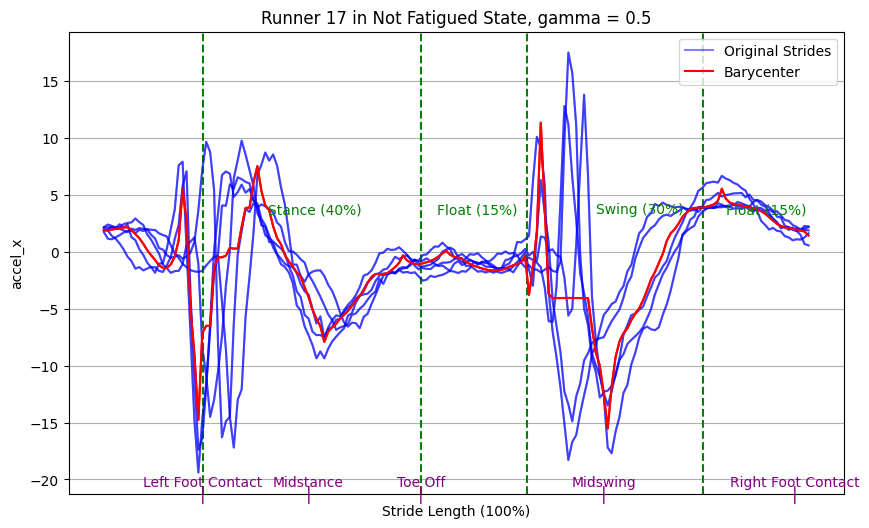

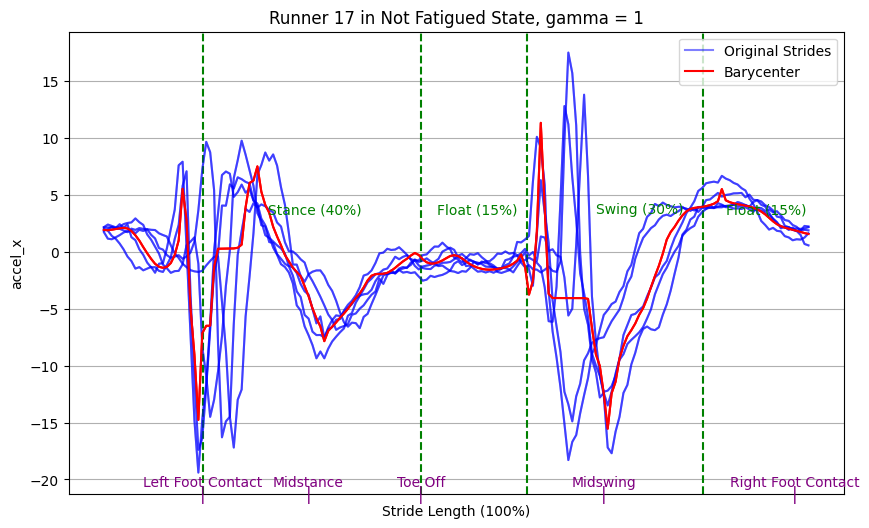

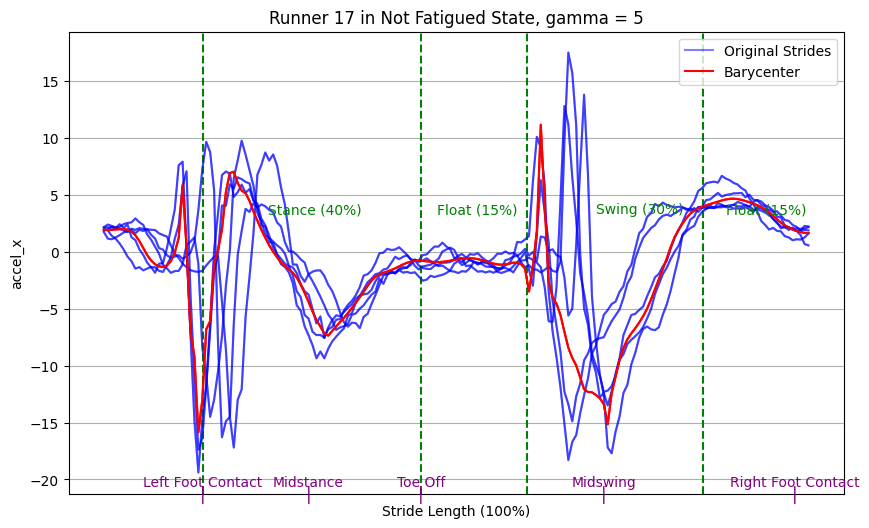

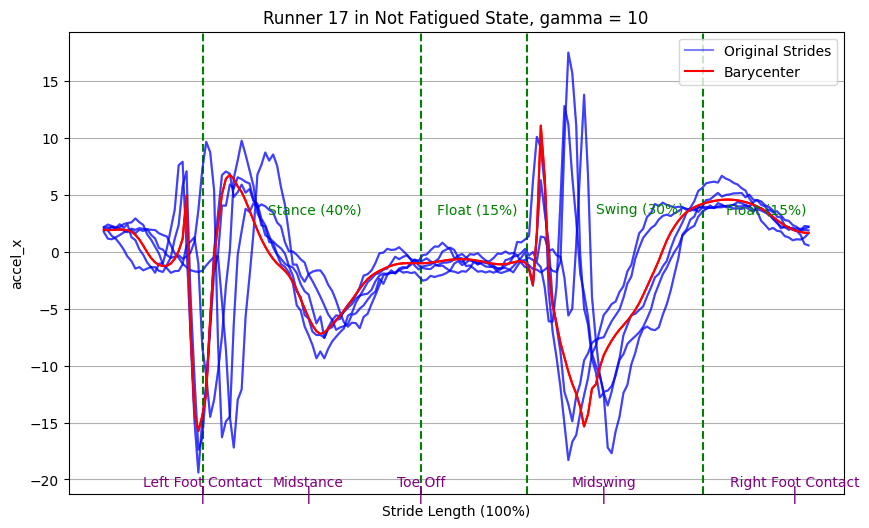

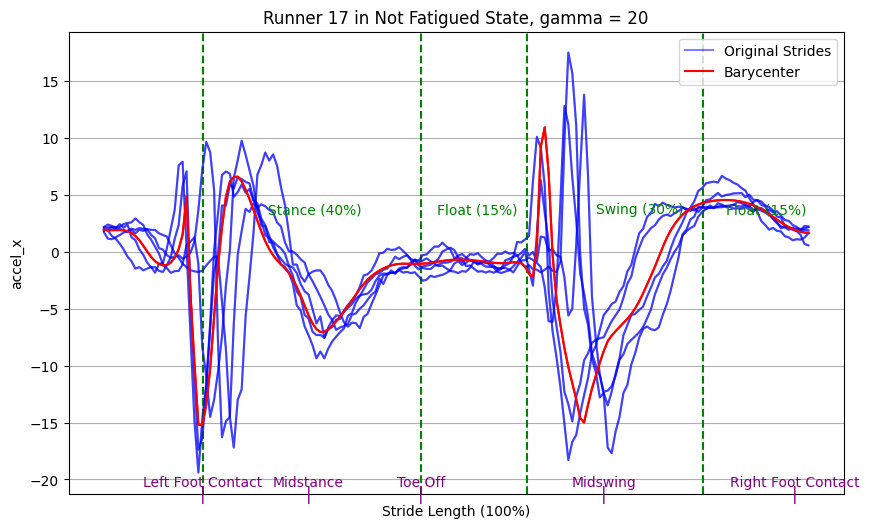

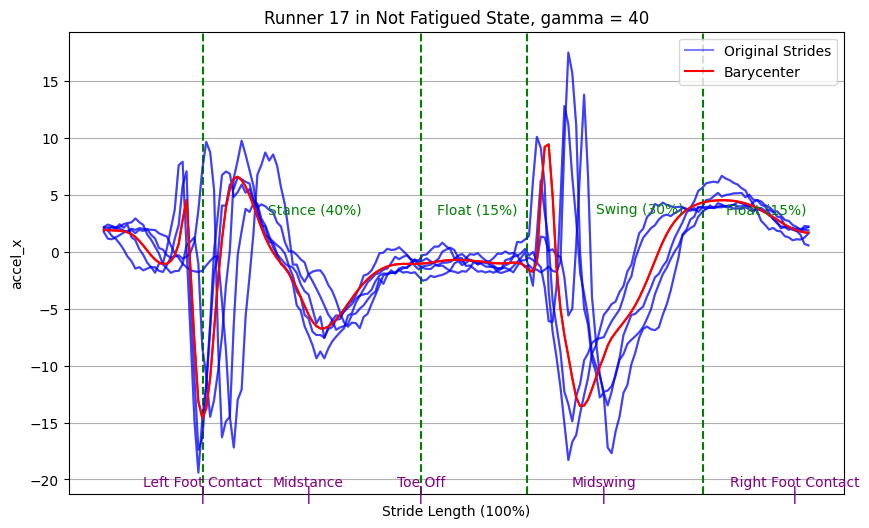

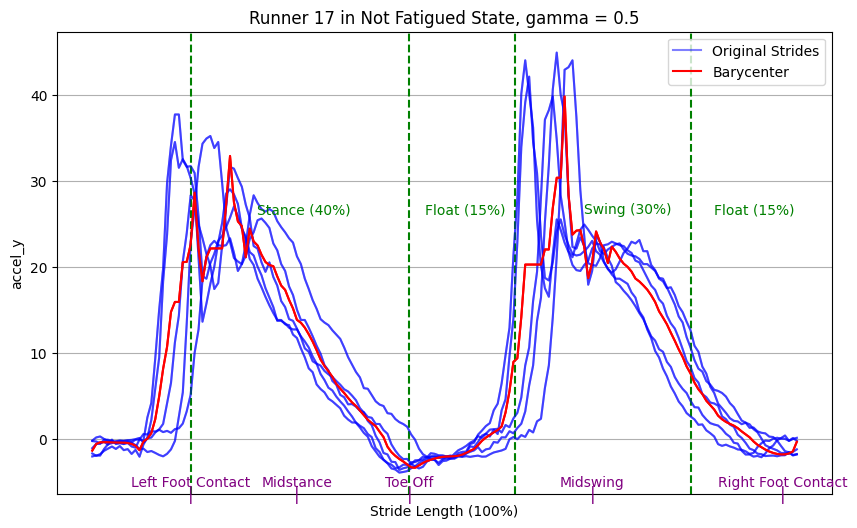

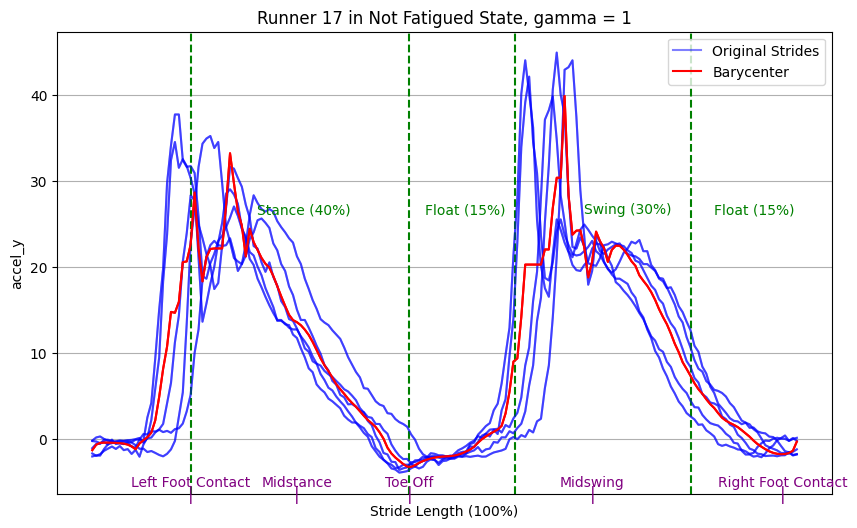

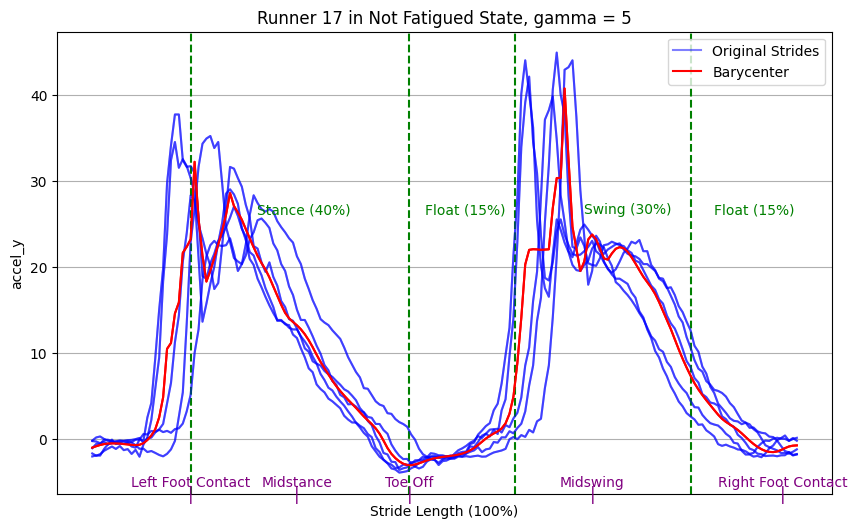

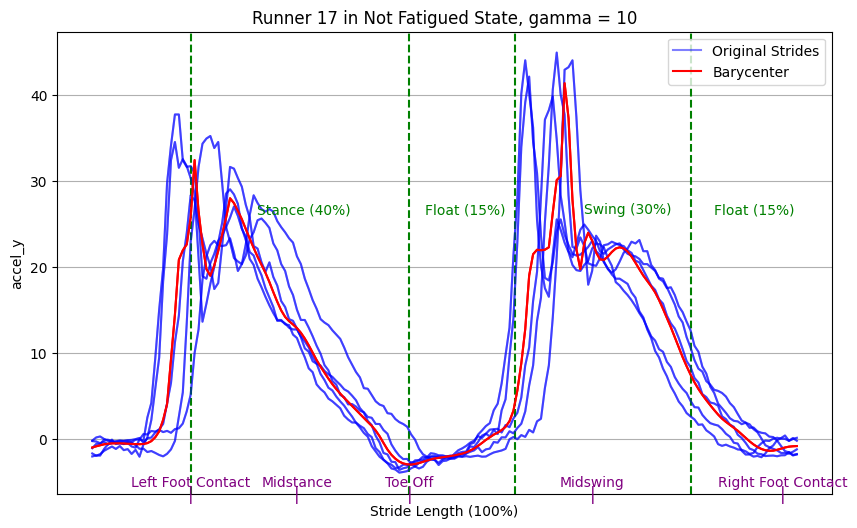

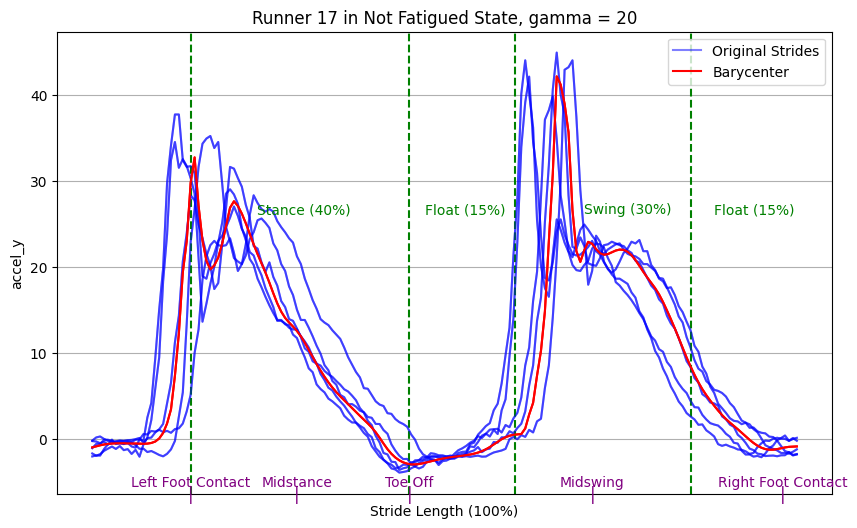

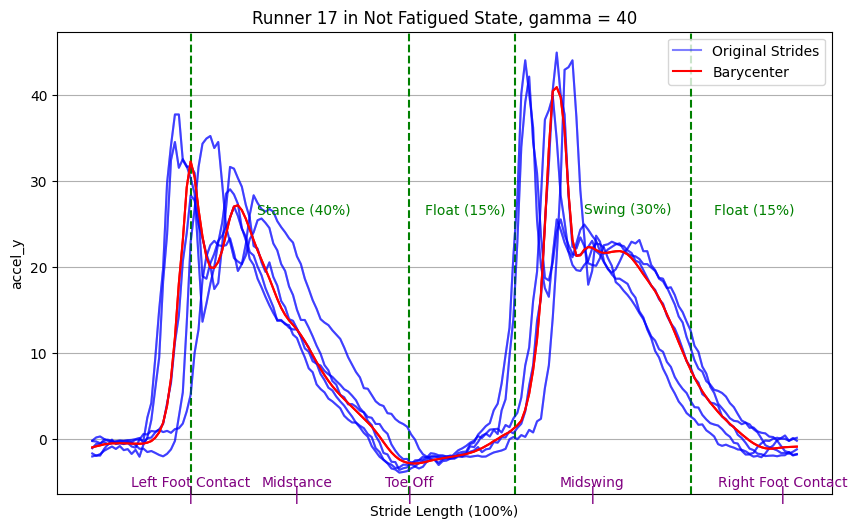

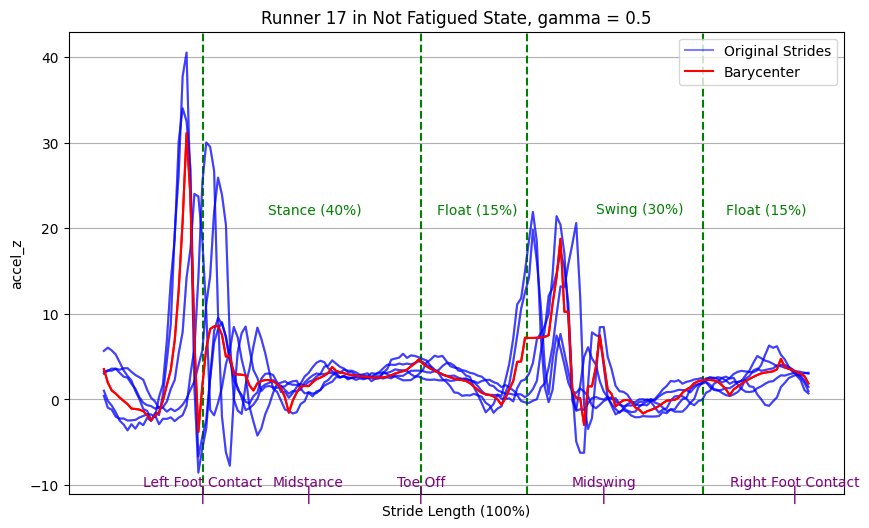

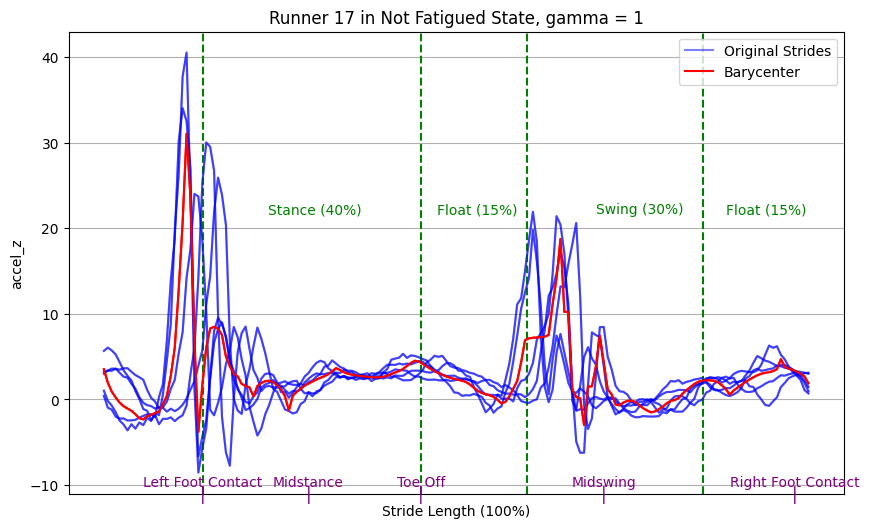

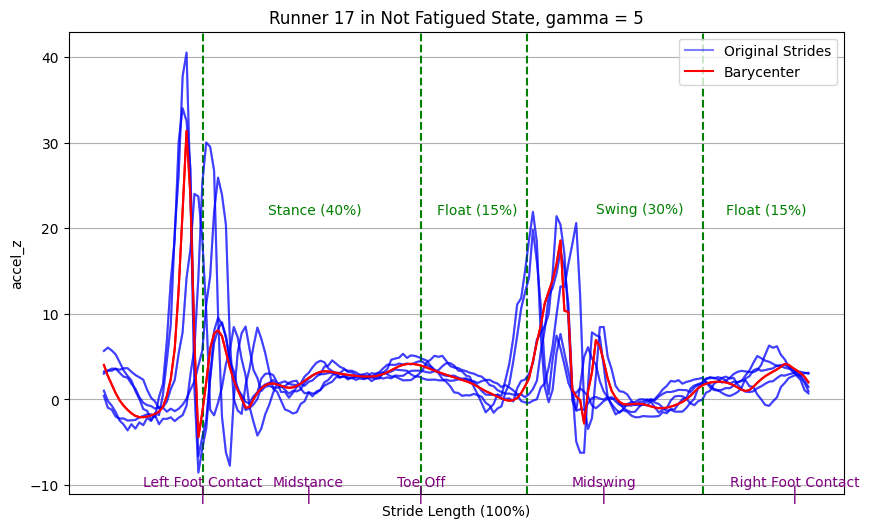

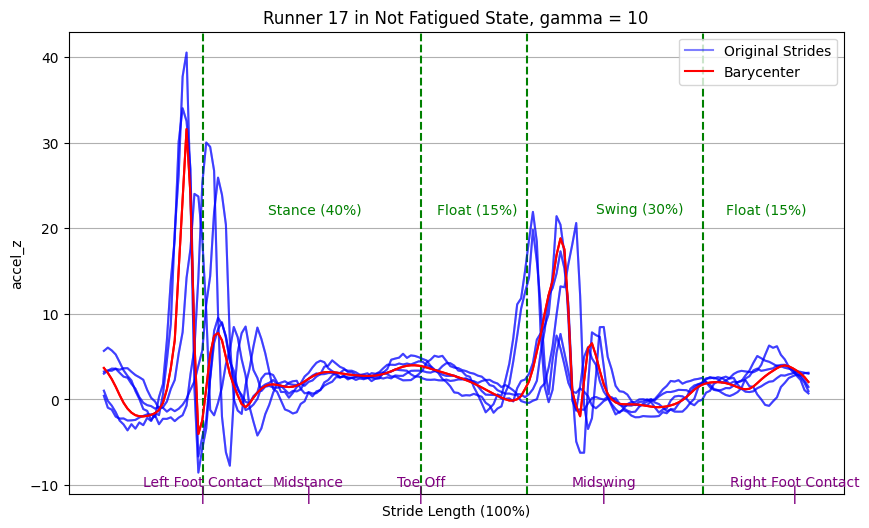

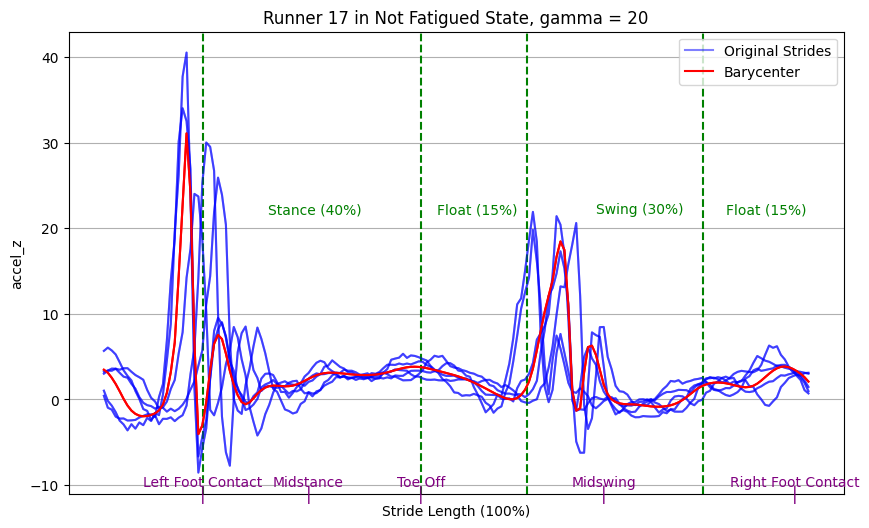

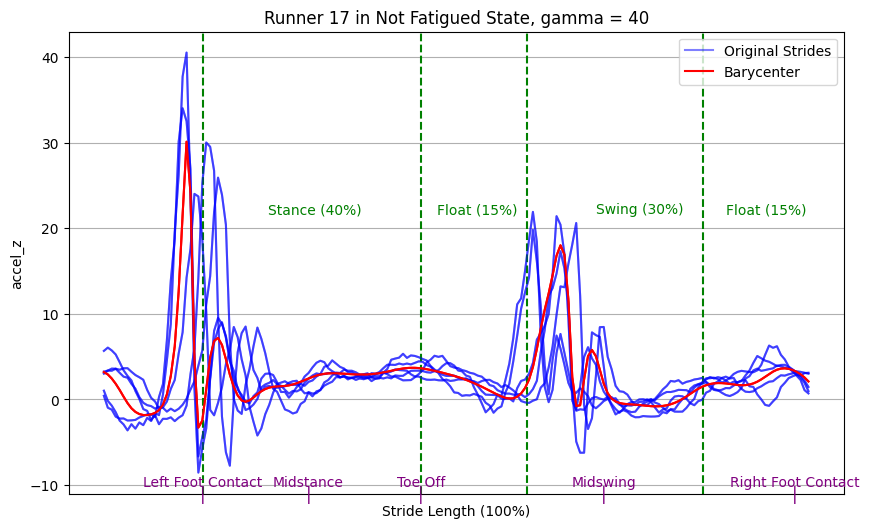

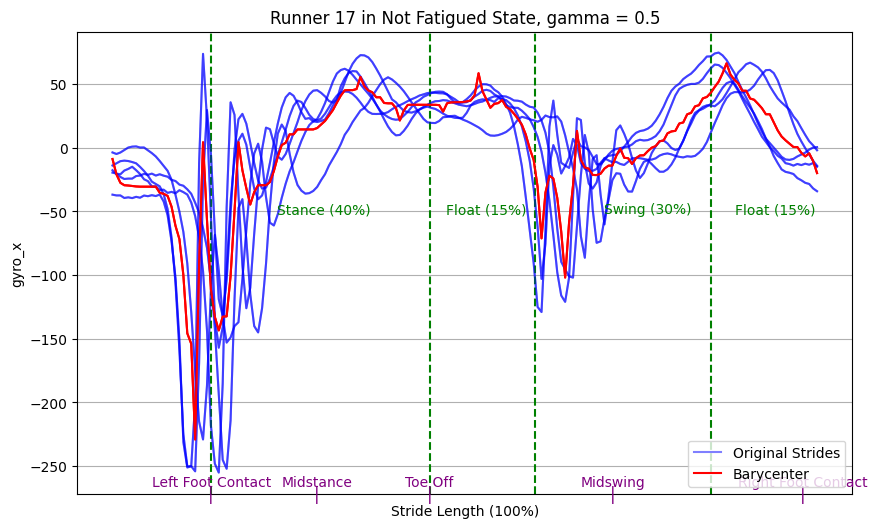

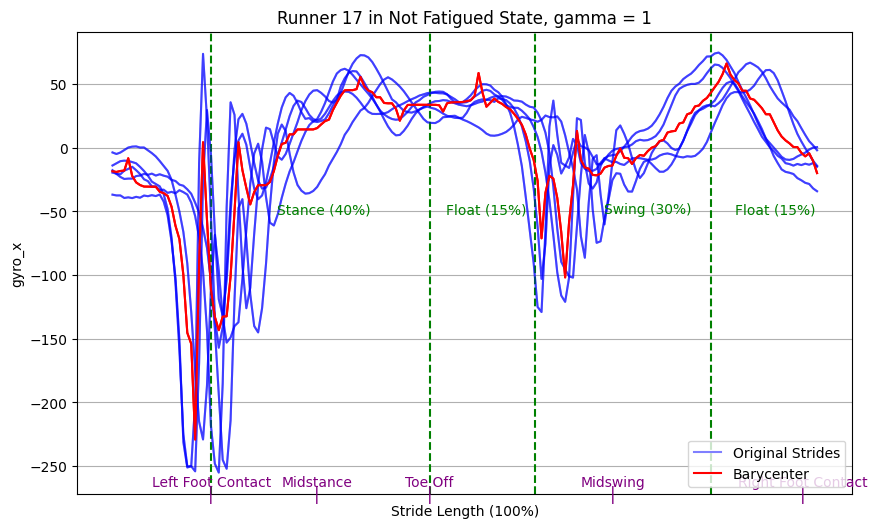

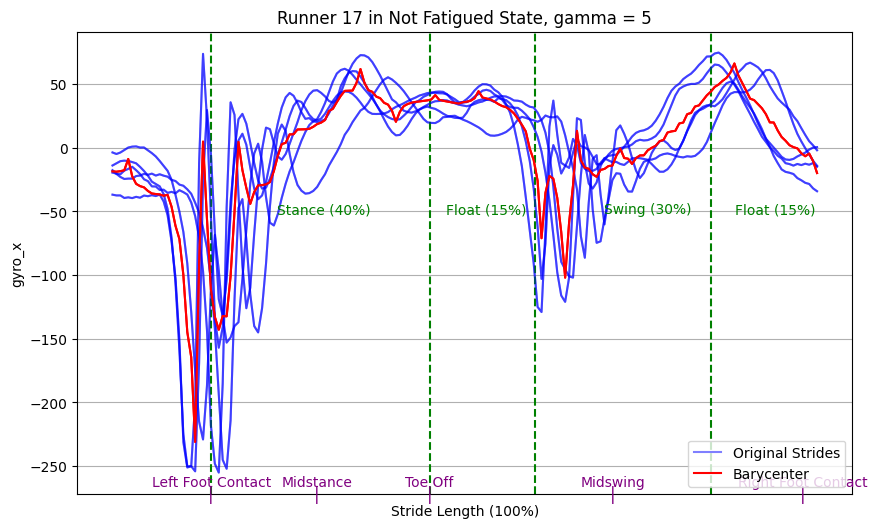

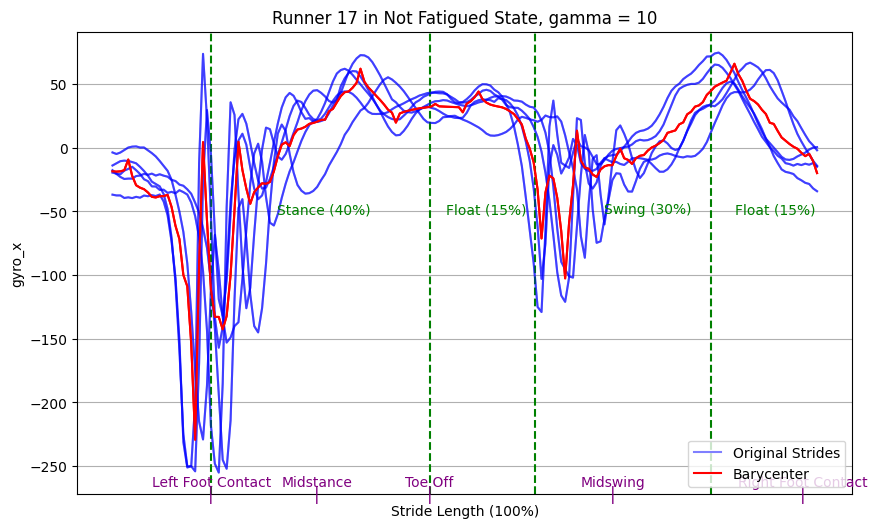

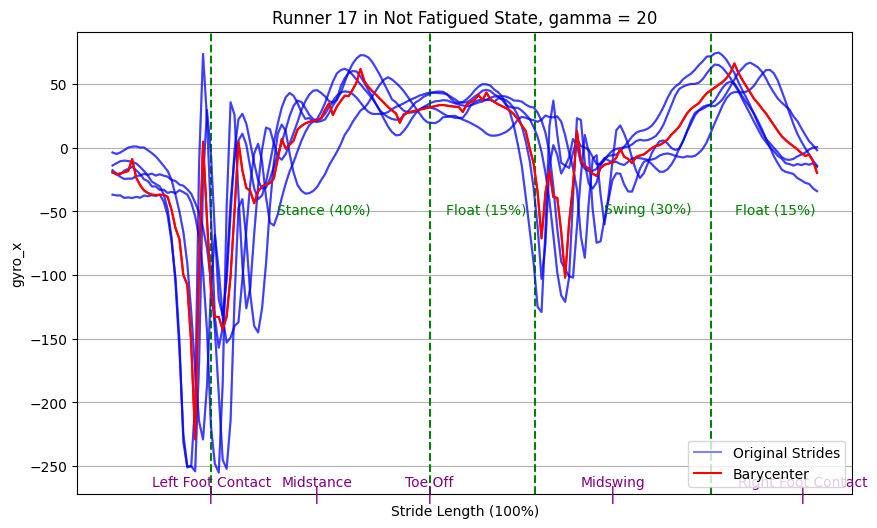

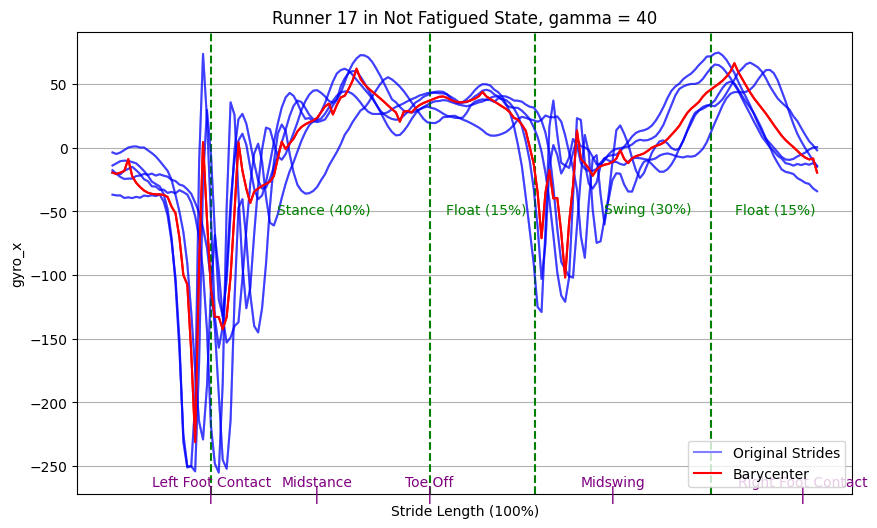

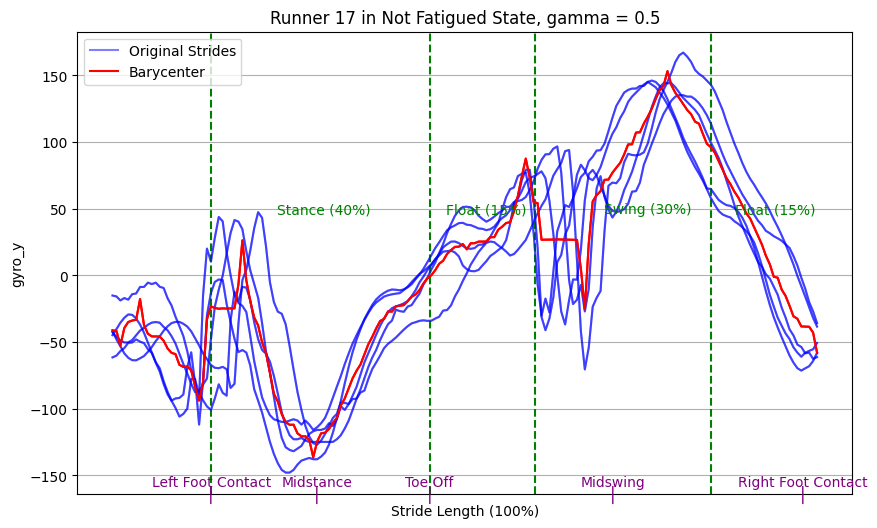

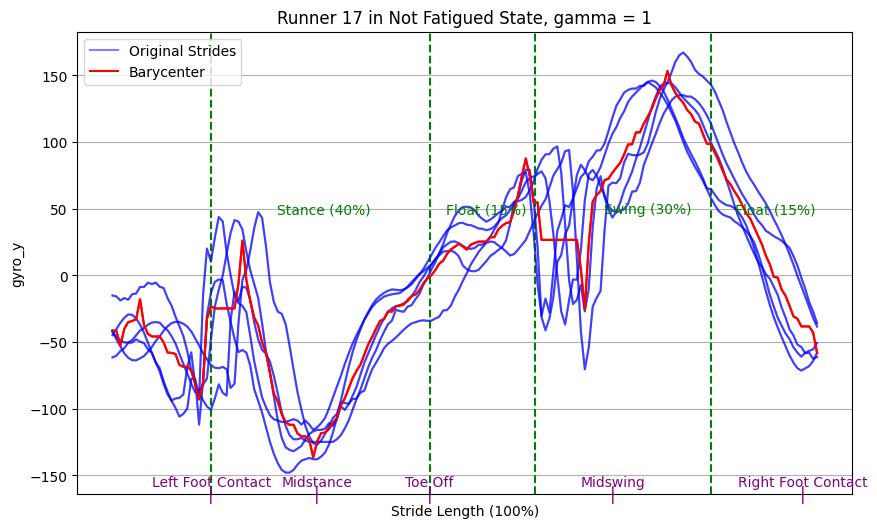

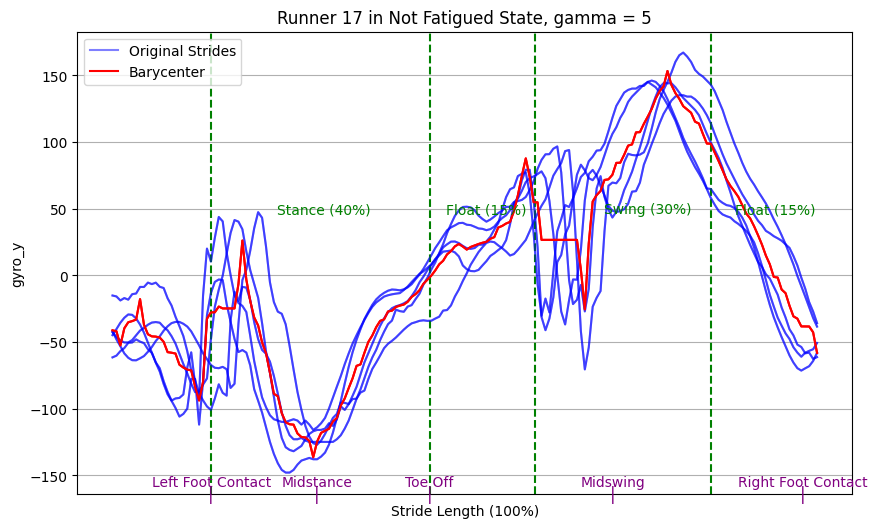

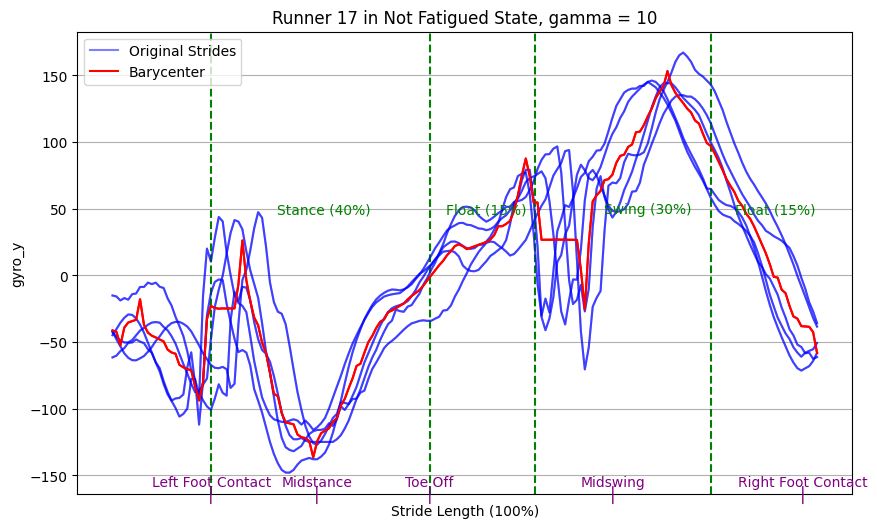

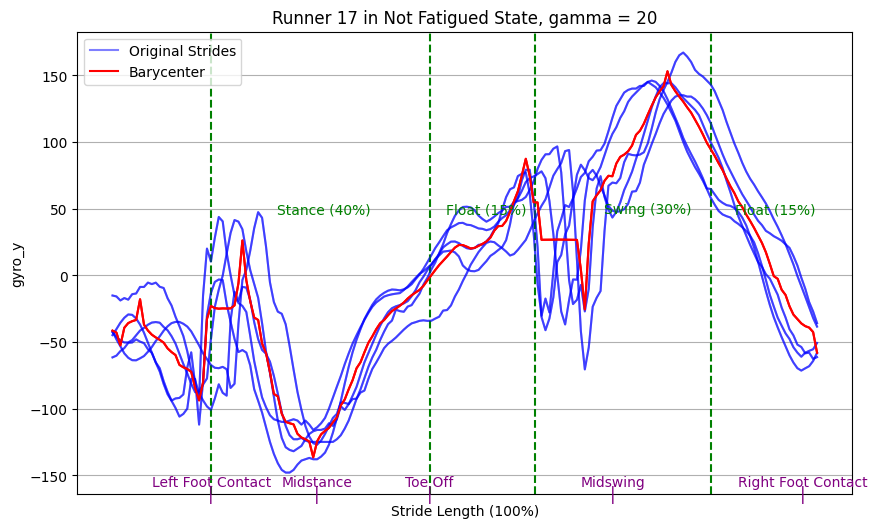

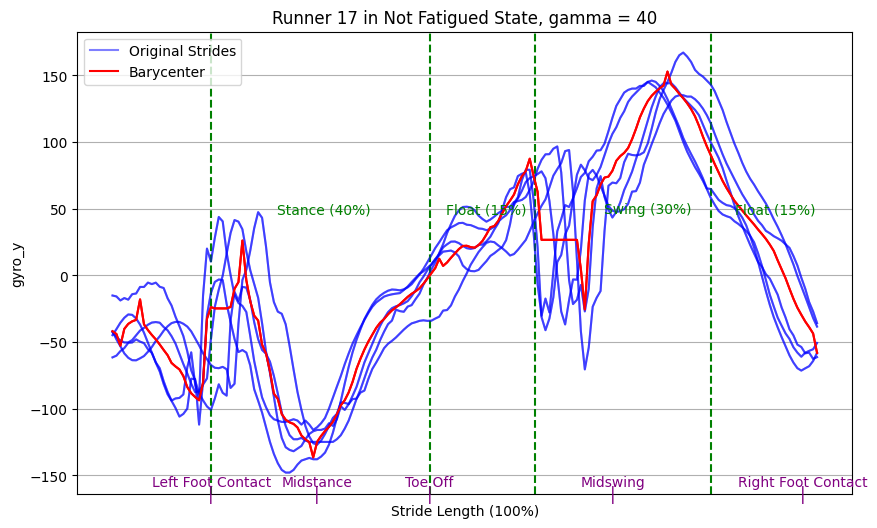

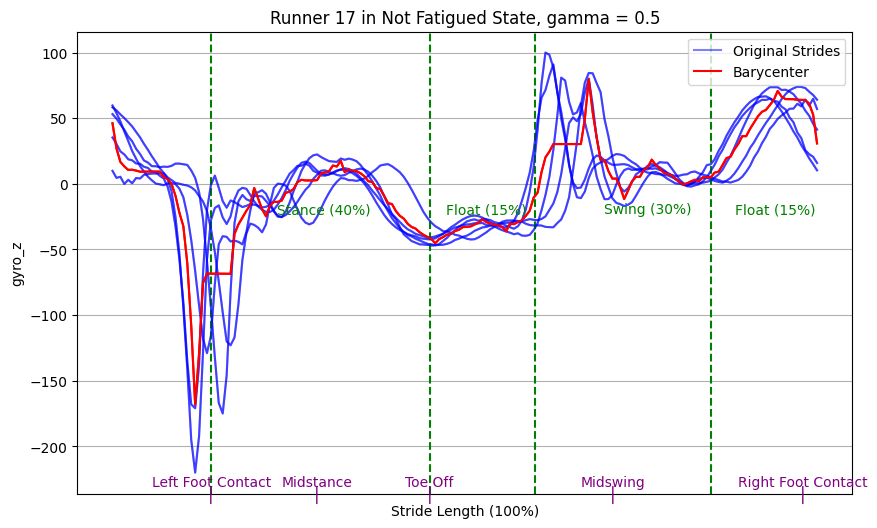

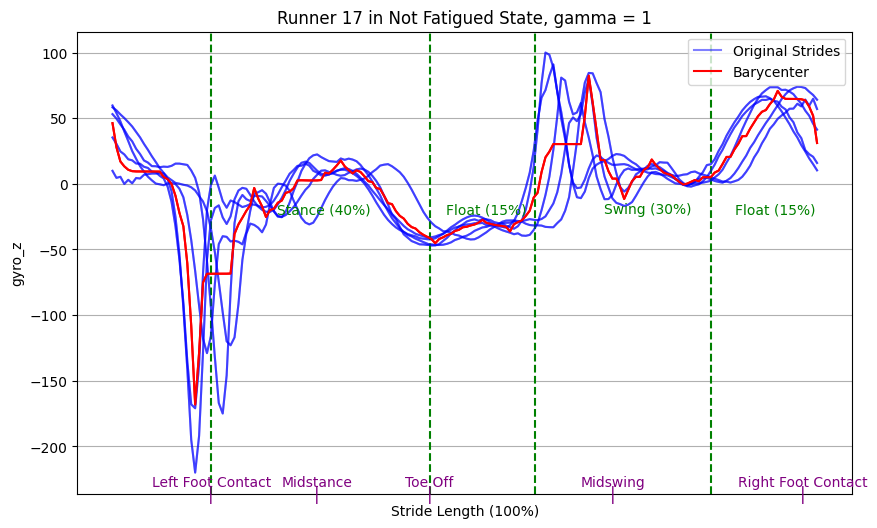

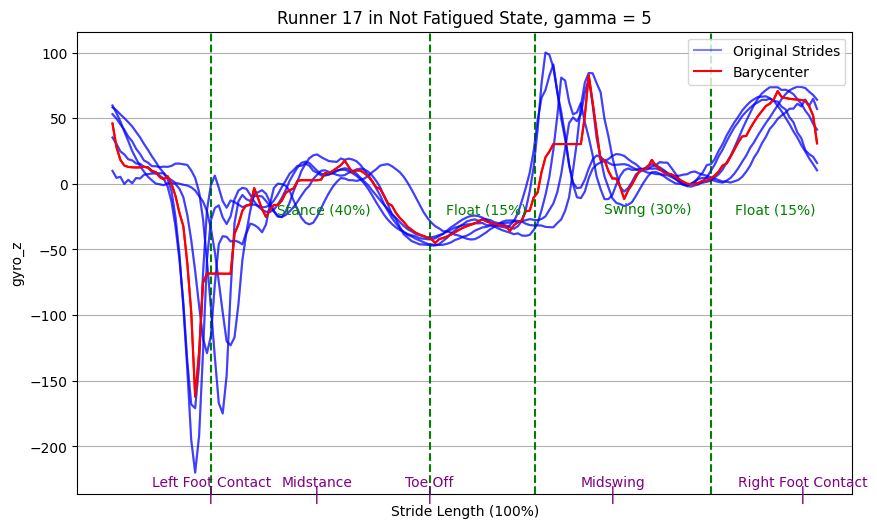

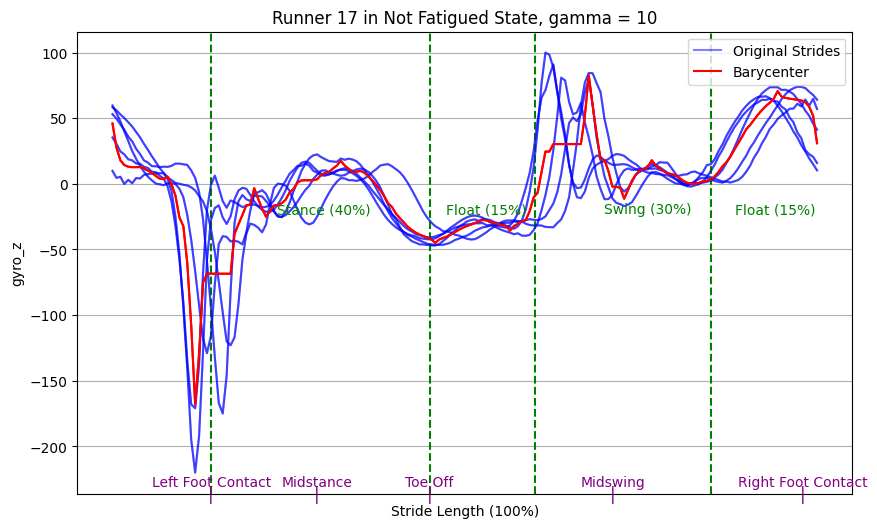

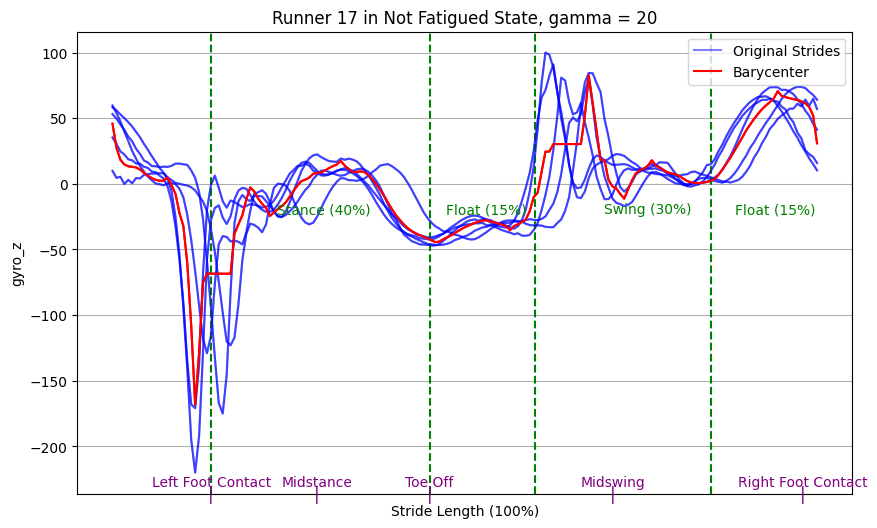

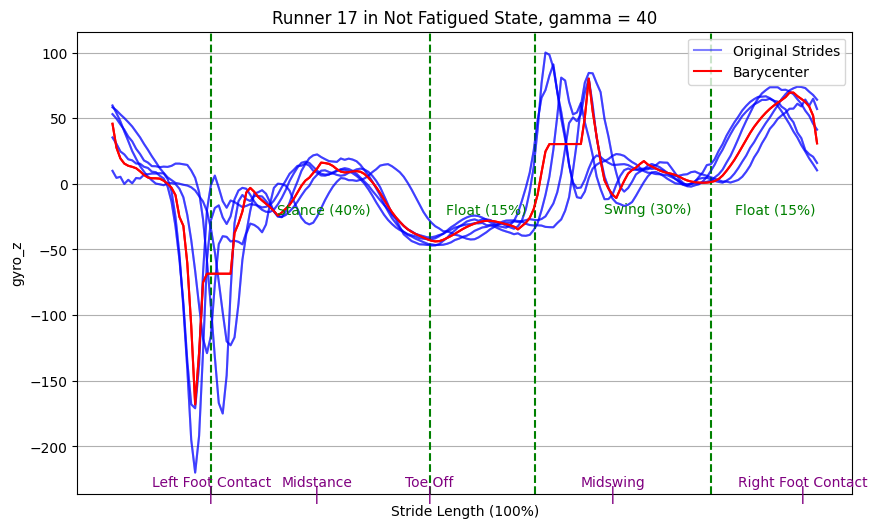

In [38]:
# Assuming `magnitude` is your DataFrame and columns 0 and 1 are 'runner_id' and 'fatigued'
gammas = [0.5, 1, 5, 10, 20, 40]
# Select the strides for the specified runner and fatigue status
import tslearn
from tslearn.barycenters import softdtw_barycenter
data_types = all_data['data_type'].unique().tolist()

for data_type in data_types:
    
    strides = all_data[(all_data['runner_id'] == runner_id) & (all_data['fatigued'] == fatigued) & (all_data['data_type']==data_type)].iloc[:, 2:-1].to_numpy()

    for gamma in gammas:
        # Compute the Soft-DTW barycenter for the first window of 5 strides
        barycenter = softdtw_barycenter(strides[:5], gamma = gamma)

        # Flatten the barycenter array
        barycenter_flat = barycenter.ravel()

        # Create a time array
        time = np.linspace(0, 100, strides.shape[1])

        # Create the plot
        plt.figure(figsize=(10, 6))

        # Plot the original strides
        for i in range(5):
            plt.plot(time, strides[i], alpha=0.5, color='blue')

        # Plot the barycenter of the strides
        plt.plot(time, barycenter_flat, color='red')

        # Add vertical dashed lines for each phase
        plt.axvline(x=14, color='green', linestyle='--')
        plt.axvline(x=45, color='green', linestyle='--')  # Stance to Float transition
        plt.axvline(x=60, color='green', linestyle='--')  # Float to Swing transition
        plt.axvline(x=85, color='green', linestyle='--')  # Swing to Float transition

        # Add labels for each phase
        plt.text(30, 0.6, 'Stance (40%)', color='green', ha='center', va='bottom', transform=plt.gca().get_xaxis_transform())
        plt.text(53, 0.6, 'Float (15%)', color='green', ha='center', va='bottom', transform=plt.gca().get_xaxis_transform())
        plt.text(76, 0.6, 'Swing (30%)', color='green', ha='center', va='bottom', transform=plt.gca().get_xaxis_transform())
        plt.text(94, 0.6, 'Float (15%)', color='green', ha='center', va='bottom', transform=plt.gca().get_xaxis_transform())

        # Set x ticks
        green_ticks = []
        plt.xticks(green_ticks, [f'{tick}%' for tick in green_ticks])

        # Add custom x ticks for specific points
        ax = plt.gca()
        specific_points = [14, 29, 45, 71, 98]  # Initial contact left foot, Midswing, Toe off, Mid swing, Contact right foot
        specific_labels = ['Left Foot Contact', 'Midstance', 'Toe Off', 'Midswing', 'Right Foot Contact']  # Labels for the specific points
        for point, label in zip(specific_points, specific_labels):
            ax.text(point, -0.02, '|', color='purple', ha='center', va='bottom', fontsize=12, transform=ax.get_xaxis_transform())
            ax.text(point, 0.01, label, color='purple', ha='center', va='bottom', fontsize=10, transform=ax.get_xaxis_transform())
        for i in range(5):
            if i == 0:
                plt.plot(time, strides[i], alpha=0.5, color='blue', label='Original Strides')
            else:
                plt.plot(time, strides[i], alpha=0.5, color='blue')

        # Plot the barycenter of the strides with a label
        plt.plot(time, barycenter_flat, color='red', label='Barycenter')

        # Add the legend
        plt.legend()

        plt.xlabel('Stride Length (100%)')
        plt.ylabel(data_type)
        plt.title(f'Runner {runner_id} in {"Fatigued" if fatigued == "F" else "Not Fatigued"} State, gamma = {gamma}')
        plt.grid(True)
    plt.show()

Above we can see the impact of rolling barcycenter smoothing with different gamma values. The higher the gamma the greater the smoothing effect. Based on the above I'll chose to move forward with a gamma value of 40. I feel lower gamma values do not provide enough smoothing and for example with a gamma value of 0.5 and 1 we still see many sharp peaks and valleys.

In [39]:
import numpy as np
from tslearn.barycenters import softdtw_barycenter
from joblib import Parallel, delayed
import time

#set gama
gamma = 40

def calculate_barycenters_rolling(runner_id, fatigued, data_type, df):
    strides = df[(df['runner_id'] == runner_id) & (df['fatigued'] == fatigued) & (df['data_type'] == data_type)]
    strides = strides.loc[:, ~strides.columns.isin(['runner_id', 'fatigued', 'data_type'])].to_numpy()
    window_barycenters = [softdtw_barycenter(strides[max(0, i-4):i+1], gamma = gamma) for i in range(len(strides))]
    return runner_id, fatigued, data_type, window_barycenters
runner_ids = all_data['runner_id'].unique()


fatiued_states = all_data['fatigued'].unique().tolist()

# Create a list of arguments for the function
args = [(runner_id, fatigued, data_type, all_data) for runner_id in runner_ids for fatigued in fatiued_states for data_type in data_types]
# Record the start time
start_time = time.time()
# Use joblib to parallelize the computation
results = Parallel(n_jobs=-1)(delayed(calculate_barycenters_rolling)(*arg) for arg in args)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"The code took {elapsed_time} seconds to run.")

The code took 313.99103331565857 seconds to run.


In [40]:
# Initialize an empty dictionary
smoothed_data = {}

# Loop over the results
for runner_id, fatigued, data_type, barycenters in results:
    # If the runner_id is not already in the dictionary, add it
    if runner_id not in smoothed_data:
        smoothed_data[runner_id] = {}
    # If the fatigued value is not already in the dictionary for this runner_id, add it
    if fatigued not in smoothed_data[runner_id]:
        smoothed_data[runner_id][fatigued] = {}
    # If the data_type is not already in the dictionary for this runner_id and fatigued value, add it
    if data_type not in smoothed_data[runner_id][fatigued]:
        smoothed_data[runner_id][fatigued][data_type] = []
    # Append the barycenters to the list for this runner_id, fatigued value, and data_type
    smoothed_data[runner_id][fatigued][data_type].extend(barycenters)

In [41]:

#check to make sure no data is missing
total_length = 0
for key, value in smoothed_data.items():
    for inner_key, inner_value in value.items():
        for inner_inner_key, inner_inner_value in inner_value.items():
            total_length += len(inner_inner_value)

print(f"Total length: {total_length}")

Total length: 36036


In [42]:
# Create new lists to store the final data
X = []
y = []
runner_ids = []

# Fill the lists from the dictionary
for runner_id, runner_states in smoothed_data.items():
    for state, data_types in runner_states.items():
        # Stack the accelerometer and gyroscope data along a new axis for each stride
        combined_data = np.stack(list(data_types.values()), axis=1)
        combined_data = np.squeeze(combined_data, axis=-1)  # Remove the last dimension
        X.extend(combined_data)
        y.extend([state] * len(combined_data))
        runner_ids.extend([runner_id] * len(combined_data))

# Convert the lists to numpy arrays
X_3D = np.array(X)
y = np.array(y)
runner_ids = np.array(runner_ids)

In [43]:
gap =4 #we ned to up the gap to 4 because we are no using rolling barycenter of 5
for split_ratio in split_ratios:
    Rocket_score_pers = []
    start_time = time.time()
    
    personal_scores_final = run_model_and_splits(X_3D,y,runner_ids,logo,n_blocks,gap,'ridge')

    print(f"Personalised Model Results for split: {split_ratio}")
    print(f"mean accuracy: {np.mean(personal_scores_final)}")
    print(f"standard deviation: {np.std(personal_scores_final)}")
    print(f"minimum accuracy: {np.min(personal_scores_final)}")
    print(f"maximum accuracy: {np.max(personal_scores_final)}")
    print('-----------------------------')

The code took 137.00774765014648 seconds to run for train size 0.6.
Personalised Model Results for split: 0.6
mean accuracy: 0.9744778902436578
standard deviation: 0.0457786724277457
minimum accuracy: 0.8111111111111111
maximum accuracy: 1.0
-----------------------------
The code took 107.41991472244263 seconds to run for train size 0.65.
Personalised Model Results for split: 0.65
mean accuracy: 0.9741532575399852
standard deviation: 0.049425586943424596
minimum accuracy: 0.8
maximum accuracy: 1.0
-----------------------------
The code took 105.16672611236572 seconds to run for train size 0.7.
Personalised Model Results for split: 0.7
mean accuracy: 0.9770228665308757
standard deviation: 0.03674247431360452
minimum accuracy: 0.8857142857142856
maximum accuracy: 1.0
-----------------------------
The code took 105.01704955101013 seconds to run for train size 0.75.
Personalised Model Results for split: 0.75
mean accuracy: 0.9809775282563289
standard deviation: 0.031443791900629424
minimum

No improvement with the smoothing, in fact the results are slightly worse. Given this and the additional time required to smooth the data we will move forward without smoothing. Just out of curiosity and to see the impact that the blocked cross validation technique, lets run the smoothed data with all the features through the standard train test split technique. We should expect to see more variations between the splits and perhaps even a split or two that performs very well. But its important to remember that the implementation of the blocked CV should provide a more realistic look at how the model will perform in the real world.

In [45]:
# Use Parallel and delayed to run your function in parallel for each split ratio
# Create an iterable for your function's inputs
inputs = list(enumerate(logo.split(X_3D, y, runner_ids)))
for split_ratio in split_ratios:
    start_time = time.time() #initializing the start time
    Rocket_score_pers = Parallel(n_jobs=-1)(delayed(process_split)(i, train_index, test_index, split_ratio) for i, (train_index, test_index) in inputs)

    print(f"Personalised Model Results for {split_ratio}")
    print(f"mean accuracy: {np.mean(Rocket_score_pers)}")
    print(f"standard deviation: {np.std(Rocket_score_pers)}")
    print(f"minimum accuracy: {np.min(Rocket_score_pers)}")
    print(f"maximum accuracy: {np.max(Rocket_score_pers)}")

    end_time = time.time() #recording the end time
    
    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Print the elapsed time
    print(f"The code took {elapsed_time} seconds to run for {split_ratio}")
    print('--------------------------------')

Personalised Model Results for 0.6
mean accuracy: 0.9368775672423796
standard deviation: 0.2049653107300381
minimum accuracy: 0.07936507936507936
maximum accuracy: 1.0
The code took 38.58930158615112 seconds to run for 0.6
--------------------------------
Personalised Model Results for 0.65
mean accuracy: 0.9724896909499536
standard deviation: 0.07107039178077294
minimum accuracy: 0.6909090909090909
maximum accuracy: 1.0
The code took 36.77580976486206 seconds to run for 0.65
--------------------------------
Personalised Model Results for 0.7
mean accuracy: 0.974833557653454
standard deviation: 0.07641292696901142
minimum accuracy: 0.6595744680851063
maximum accuracy: 1.0
The code took 36.83179450035095 seconds to run for 0.7
--------------------------------
Personalised Model Results for 0.75
mean accuracy: 0.9939076805147424
standard deviation: 0.01705741495367604
minimum accuracy: 0.9247311827956989
maximum accuracy: 1.0
The code took 36.785496950149536 seconds to run for 0.75
-----

Interesting, we see exactly what we thought we would. The 60/40, 65/35 and 70/30 splits all perform the worse than the block cv while the 75/25 and 80/20 peform way better. While it may be tempting to choose this approach its important to remember that the blocked cv provides a more realistic look at model performance in the real world.

# Conclusion

#### 1. Replicate the results from the original paper.
#### 2. Improved the speed of the model by ~18x through parallel processing (used 96vCPU 192GiB aws environment).
#### 3. Introduced blocked cross validation to make the results more stable and representative of the real world.
#### 4. Explored multivariate models and saw noticeable improvements in mean accuracy, standard deviation and minimum accuracy.
#### 5. Experimented with rolling barycenter smoothing to reduce noise in the inputs, however saw no improvement.